## Evaluate Pearson correlation score

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import umap
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

from sklearn.neighbors import NearestNeighbors
import scipy.stats

### Load results

In [2]:
res_path = "Results/INSPIRE_registration_merfish"
adata_0_ours = sc.read_h5ad(res_path + "/adata_st_list_0_loc_aligned.h5ad")
adata_1_ours = sc.read_h5ad(res_path + "/adata_st_list_1_loc_aligned.h5ad")

In [3]:
data_dir = "data/MERFISH_mouse_hypothalamus"
spatial_data = pd.read_csv(data_dir + '/Moffitt_and_Bambah-Mukku_et_al_merfish_all_cells.csv', 
                           sep=',', index_col=0)
spatial_data = spatial_data[spatial_data.Animal_ID.values==1]

gene_exp = spatial_data[spatial_data.columns[8:]]
gene_exp = gene_exp.drop(columns = ['Blank_1','Blank_2','Blank_3','Blank_4','Blank_5','Fos'])

Bregma_list = [-0.09, -0.04]

meta_st = spatial_data[spatial_data.columns[:8]]
adata_st_list = []
for Bregma in Bregma_list:
    adata_st_i = ad.AnnData(X=gene_exp[(meta_st.Bregma.values==Bregma)].values)
    adata_st_i.obs = meta_st[(meta_st.Bregma.values==Bregma)]
    adata_st_i.var.index = gene_exp.columns
    adata_st_i.obsm['spatial'] = np.concatenate((adata_st_i.obs.Centroid_X.values.reshape(-1, 1),
                                                 adata_st_i.obs.Centroid_Y.values.reshape(-1, 1)), axis=1)
    adata_st_i = adata_st_i[adata_st_i.obs["Cell_class"].values.astype(str) != "Ambiguous", :]
    adata_st_list.append(adata_st_i)

In [4]:
adata_0 = adata_st_list[0]
adata_0.obs.index = adata_0.obs.index + "-0"

adata_1 = adata_st_list[1]
adata_1.obs.index = adata_1.obs.index + "-1"

In [5]:
adata_0.obsm["loc_ours"] = adata_0_ours[adata_0.obs.index, :].obsm["loc_aligned"]
adata_1.obsm["loc_ours"] = adata_1_ours[adata_1.obs.index, :].obsm["loc_aligned"]

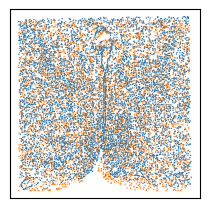

In [6]:
s = 1
f = plt.figure(figsize=(2.45, 2.45))

ax2 = f.add_subplot(1,1,1)
ax2.scatter(adata_1.obsm["loc_ours"][:,0], adata_1.obsm["loc_ours"][:,1], facecolors="tab:orange", s=s, rasterized=True, marker='o', edgecolors='none')
ax2.scatter(adata_0.obsm["loc_ours"][:,0], adata_0.obsm["loc_ours"][:,1], facecolors="tab:blue", s=s, rasterized=True, marker='o', edgecolors='none')
ax2.axis('equal')
ax2.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)

### Calculate the score

In [7]:
k = 6

neigh = NearestNeighbors(n_neighbors=k, metric="euclidean")
neigh.fit(adata_1.obsm["loc_ours"])
NN = neigh.kneighbors(adata_0.obsm["loc_ours"], k, return_distance=False)

PCC = []
for i in range(NN.shape[0]):
    x0 = adata_0.X[i, :]
    x1_mat = adata_1.X[NN[i, :], :]
    pcc_cell = np.corrcoef(x0.reshape((1,-1)), x1_mat)[0, :][1:]
    PCC.append(np.max(pcc_cell))

print("Pearson correlation score =", np.mean(PCC))

Pearson correlation score = 0.5984000433179806
